In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.preprocessing import LabelEncoder
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# Load labels
labels_df = pd.read_csv('/Users/namigabbasov/Desktop/Projects-Fall-2024/RetinoVision/FGADR/labels.csv')
image_dir = '/Users/namigabbasov/Desktop/Projects-Fall-2024/RetinoVision/FGADR/images'

In [ ]:
# prepare label encoder
label_encoder = LabelEncoder()
labels_df['class'] = label_encoder.fit_transform(labels_df['class'])
num_classes = len(label_encoder.classes_)

# split data into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['class'], random_state=42)

In [ ]:
# Define a custom dataset
class ImageDataset(Dataset):
    def __init__(self, labels_df, image_dir, transform=None):
        self.labels_df = labels_df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]['name']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label = self.labels_df.iloc[idx]['class']

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets and data loaders
train_dataset = ImageDataset(train_df, image_dir, transform=transform)
val_dataset = ImageDataset(val_df, image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# load pre-trained ViT model from Hugging Face
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# microsoft/swin-tiny-patch4-window7-224
# google/vit-large-patch32-384

In [ ]:
# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=3e-5)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# Evaluation function
def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

In [1]:
# Training loop
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    val_loss, val_accuracy = evaluate(model, val_loader)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Save trained model
torch.save(model.state_dict(), '/Users/namigabbasov/Desktop/Projects-Fall-2024/RetinoVision/FGADR/vit_retinopathy.pth')

print('Training complete!')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|███████████████████████████████| 47/47 [04:21<00:00,  5.56s/it]


Epoch 1, Loss: 1.2276, Accuracy: 57.84%, Val Loss: 0.9670, Val Accuracy: 63.69%


Epoch 2/10: 100%|███████████████████████████████| 47/47 [04:18<00:00,  5.51s/it]


Epoch 2, Loss: 0.9110, Accuracy: 64.29%, Val Loss: 0.8877, Val Accuracy: 63.96%


Epoch 3/10: 100%|███████████████████████████████| 47/47 [04:32<00:00,  5.80s/it]


Epoch 3, Loss: 0.8111, Accuracy: 68.16%, Val Loss: 0.8192, Val Accuracy: 67.21%


Epoch 4/10: 100%|███████████████████████████████| 47/47 [05:39<00:00,  7.23s/it]


Epoch 4, Loss: 0.7094, Accuracy: 73.46%, Val Loss: 0.7771, Val Accuracy: 69.11%


Epoch 5/10: 100%|███████████████████████████████| 47/47 [04:22<00:00,  5.58s/it]


Epoch 5, Loss: 0.5602, Accuracy: 81.33%, Val Loss: 0.7632, Val Accuracy: 70.46%


Epoch 6/10: 100%|███████████████████████████████| 47/47 [04:16<00:00,  5.47s/it]


Epoch 6, Loss: 0.4521, Accuracy: 88.73%, Val Loss: 0.8274, Val Accuracy: 68.83%


Epoch 7/10: 100%|███████████████████████████████| 47/47 [04:12<00:00,  5.37s/it]


Epoch 7, Loss: 0.3338, Accuracy: 91.11%, Val Loss: 0.8254, Val Accuracy: 69.65%


Epoch 8/10: 100%|███████████████████████████████| 47/47 [04:16<00:00,  5.47s/it]


Epoch 8, Loss: 0.2501, Accuracy: 94.84%, Val Loss: 1.2213, Val Accuracy: 55.56%


Epoch 9/10: 100%|███████████████████████████████| 47/47 [04:25<00:00,  5.64s/it]


Epoch 9, Loss: 0.3925, Accuracy: 87.58%, Val Loss: 0.9165, Val Accuracy: 67.48%


Epoch 10/10: 100%|██████████████████████████████| 47/47 [04:24<00:00,  5.62s/it]


Epoch 10, Loss: 0.1839, Accuracy: 96.27%, Val Loss: 0.9099, Val Accuracy: 69.92%
Training complete!


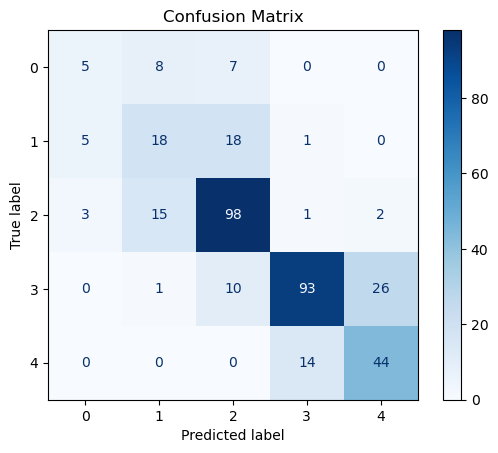

In [6]:
# Function to generate confusion matrix
def plot_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(model, val_loader)